In [1]:
import tensorflow as tf

class GaussianAttention(tf.keras.layers.Layer):
    def __init__(self, return_sequences=True, **kwargs):
        super(GaussianAttention, self).__init__(**kwargs)
        self.return_sequences = return_sequences

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1),
                                 initializer="random_normal", trainable=True)
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1),
                                 initializer="zeros", trainable=True)
        super(GaussianAttention, self).build(input_shape)

    def call(self, x):
        e = tf.matmul(x, self.W) + self.b
        a = tf.nn.softmax(e, axis=1)
        output = x * a

        if self.return_sequences:
            return output

        return tf.reduce_sum(output, axis=1)


In [4]:
time_steps_encoder=28
num_encoder_tokens=2048
latent_dim=512
time_steps_decoder=10
num_decoder_tokens=1500
batch_size=320
epochs = 25
save_model_path = './'
import tensorflow as tf
import graphviz
import pydot
from tensorflow.keras.utils import plot_model
encoder_inputs_global = tf.keras.layers.Input(shape=(time_steps_encoder, 2048), name="encoder_inputs_global")
encoder_inputs_motion = tf.keras.layers.Input(shape=(time_steps_encoder, 4096), name="encoder_inputs_motion")
encoder_inputs_local = tf.keras.layers.Input(shape=(time_steps_encoder, 4096), name="encoder_inputs_local")

encoder_inputs = tf.keras.layers.Concatenate(axis=2)([encoder_inputs_global, encoder_inputs_motion, encoder_inputs_local])

encoder = tf.keras.layers.LSTM(latent_dim, return_state=True, return_sequences=True, name='encoder_lstm1')
encoder_seq_output, state_h, state_c = encoder(encoder_inputs)

attention_output = GaussianAttention(return_sequences=True, name='attention')(encoder_seq_output)

encoder = tf.keras.layers.LSTM(latent_dim, return_state=True, return_sequences=True, name='encoder_lstm2')
_, state_h_1, state_c_1 = encoder(attention_output)
encoder_states = [state_h_1,state_c_1]

# encoder_states = [state_h]

decoder_inputs = tf.keras.layers.Input(shape=(time_steps_decoder, num_decoder_tokens), name="decoder_inputs")
decoder_lstm = tf.keras.layers.LSTM(latent_dim, return_sequences=True, return_state=True, name='decoder_lstm')
decoder_outputs, _ , _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_outputs = tf.keras.layers.Dropout(0.3)(decoder_outputs)
decoder_dense = tf.keras.layers.Dense(num_decoder_tokens, activation='sigmoid', name='decoder_sigmoid')
decoder_outputs = decoder_dense(decoder_outputs)

model = tf.keras.models.Model([encoder_inputs_global,encoder_inputs_motion, encoder_inputs_local, decoder_inputs], decoder_outputs)

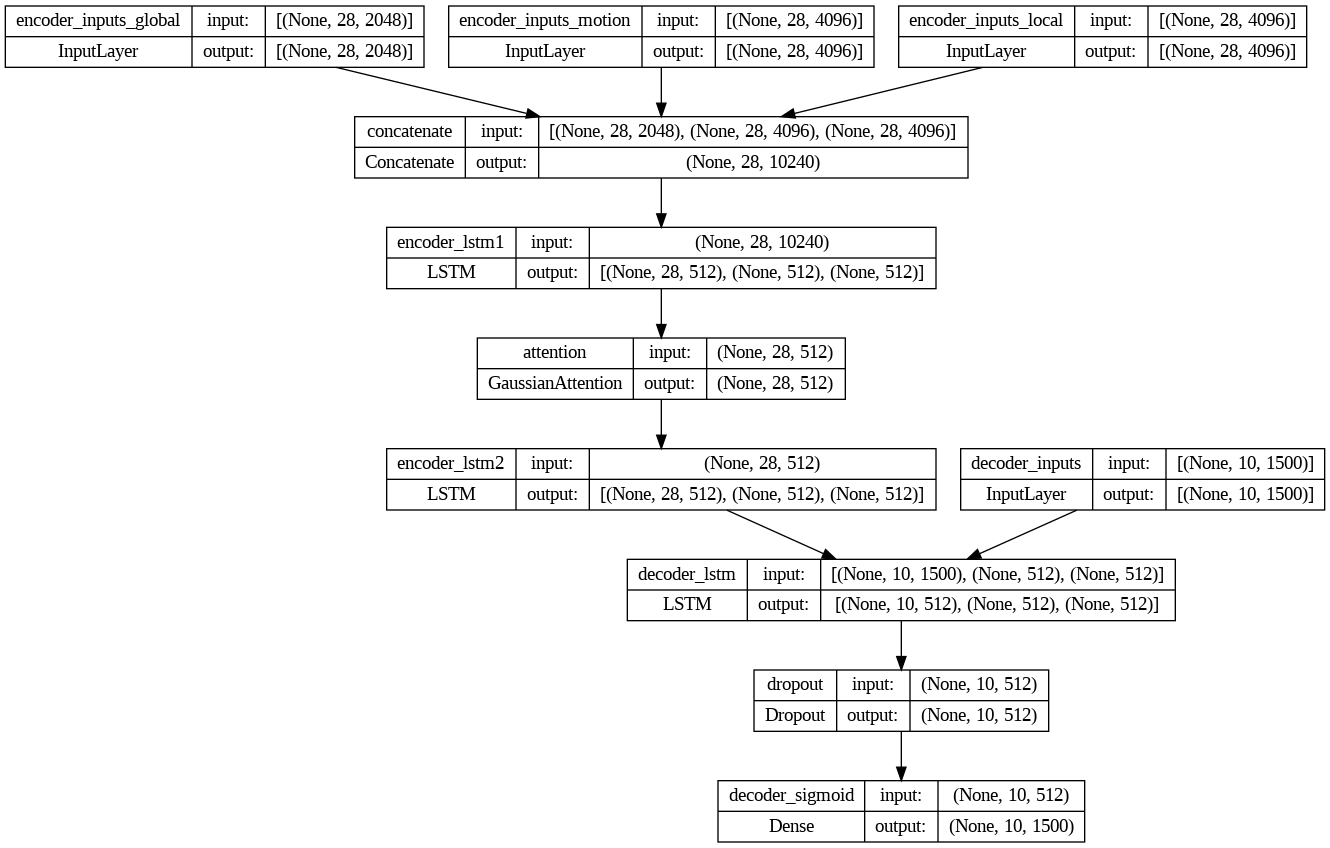

In [5]:
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [12]:
found=[]
with open('testing_id.txt') as testing_file:
  lines = testing_file.readlines()
  for filename in lines:
    filename = filename.strip()
    found.append(filename)

In [14]:
#Prepare training and validation data
import pandas as pd
df = pd.read_csv('data.csv')
test_ids = found[-100:]

references_list=[]
ref_dict={'annotations':[]}
for i in range(len(test_ids)):
  df_temp=df.loc[df['VideoID']==test_ids[i]]
  references=[]
  for _, row in df_temp.iterrows():
    reference = row['Description'].split()
    ref_dict['annotations'].append({u'video_id':i,u'caption':row['Description']})
    references.append(reference)
  references_list.append(references)

print(ref_dict)

{'annotations': [{'video_id': 0, 'caption': 'a man is holding a frog in his hand'}, {'video_id': 0, 'caption': 'a person holds a frog'}, {'video_id': 0, 'caption': 'a man is holding a frog'}, {'video_id': 0, 'caption': 'a man is catching a frog'}, {'video_id': 0, 'caption': 'a man is holding an amphibian'}, {'video_id': 0, 'caption': 'a man is holding frog in his hands'}, {'video_id': 0, 'caption': 'a man holds a small'}, {'video_id': 0, 'caption': 'a man is holding a frog'}, {'video_id': 0, 'caption': 'a woman is handling a frog'}, {'video_id': 0, 'caption': 'a man is holding a frog'}, {'video_id': 0, 'caption': 'a man is holding a frog'}, {'video_id': 0, 'caption': 'a purple frog held by a man in his hands is making noise'}, {'video_id': 0, 'caption': 'the man picked up the frog in his hands'}, {'video_id': 0, 'caption': 'the man is holding a frog'}, {'video_id': 0, 'caption': 'a frog crawls along a man s arm'}, {'video_id': 0, 'caption': 'the man held a frog in his hand'}, {'video_i

In [15]:
hypotheses = []
count=0
hyp_dict={'annotations':[]}
with open('test_output.txt','r') as file:
  for line in file:
    vid = line.split(',')[0]
    hyp = line.split(',')[1]
    hyp=hyp.split('\n')[0]
    hypotheses.append(hyp)
    hyp_dict['annotations'].append({u'video_id':count,u'caption':hyp})
    count=count+1

print(hyp_dict)

{'annotations': [{'video_id': 0, 'caption': 'a man is holding a woman'}, {'video_id': 1, 'caption': 'a man is playing a ball'}, {'video_id': 2, 'caption': 'two men are fighting'}, {'video_id': 3, 'caption': 'a woman is washing her hands'}, {'video_id': 4, 'caption': 'a man is talking on a phone'}, {'video_id': 5, 'caption': 'a group of people are riding a car'}, {'video_id': 6, 'caption': 'a plane is flying'}, {'video_id': 7, 'caption': 'a man is doing exercise'}, {'video_id': 8, 'caption': 'a man is singing'}, {'video_id': 9, 'caption': 'a plane is flying'}, {'video_id': 10, 'caption': 'a man is playing a guitar'}, {'video_id': 11, 'caption': 'a man is jumping'}, {'video_id': 12, 'caption': 'a band is performing on a stage'}, {'video_id': 13, 'caption': 'a woman is slicing a potato'}, {'video_id': 14, 'caption': 'a man is slicing a potato'}, {'video_id': 15, 'caption': 'a man is riding a bike'}, {'video_id': 16, 'caption': 'a man is playing a guitar'}, {'video_id': 17, 'caption': 'a m

In [16]:
!pip install "git+https://github.com/salaniz/pycocoevalcap.git"

  Cloning https://github.com/salaniz/pycocoevalcap.git to /tmp/pip-req-build-tm9vobvh
  Running command git clone --filter=blob:none --quiet https://github.com/salaniz/pycocoevalcap.git /tmp/pip-req-build-tm9vobvh
  Resolved https://github.com/salaniz/pycocoevalcap.git to commit a24f74c408c918f1f4ec34e9514bc8a76ce41ffd
  Preparing metadata (setup.py) ... done
  Created wheel for pycocoevalcap: filename=pycocoevalcap-1.2-py3-none-any.whl size=104312246 sha256=fdda12815c30a8c17ecd7e98d2a6229f5f549f86901b053497ec88f0bceb151b
  Stored in directory: /tmp/pip-ephem-wheel-cache-xprtoyv6/wheels/57/de/9f/7aa9ae75f4e4733cc4b66b5c3a65a05de62a28e8111649fee5
Successfully built pycocoevalcap


In [17]:
from pycocoevalcap.tokenizer.ptbtokenizer import PTBTokenizer
from pycocoevalcap.bleu.bleu import Bleu
from pycocoevalcap.meteor.meteor import Meteor
from pycocoevalcap.rouge.rouge import Rouge
from pycocoevalcap.cider.cider import Cider

class COCOEvalCap:
    def __init__(self,images,gts,res):
        self.evalImgs = []
        self.eval = {}
        self.imgToEval = {}
        self.params = {'video_id': images}
        self.gts = gts
        self.res = res

    def evaluate(self):
        imgIds = self.params['video_id']
        gts = self.gts
        res = self.res

        # =================================================
        # Set up scorers
        # =================================================
        print('tokenization...')
        tokenizer = PTBTokenizer()
        gts  = tokenizer.tokenize(gts)
        res = tokenizer.tokenize(res)

        # =================================================
        # Set up scorers
        # =================================================
        print('setting up scorers...')
        scorers = [
            (Bleu(4), ["Bleu_1", "Bleu_2", "Bleu_3", "Bleu_4"]),
            (Meteor(),"METEOR"),
            (Rouge(), "ROUGE_L"),
            (Cider(), "CIDEr")
        ]

        # =================================================
        # Compute scores
        # =================================================
        eval = {}
        for scorer, method in scorers:
            print('computing %s score...'%(scorer.method()))
            score, scores = scorer.compute_score(gts, res)
            if type(method) == list:
                for sc, scs, m in zip(score, scores, method):
                    self.setEval(sc, m)
                    self.setImgToEvalImgs(scs, imgIds, m)
                    print("%s: %0.3f"%(m, sc))
            else:
                self.setEval(score, method)
                self.setImgToEvalImgs(scores, imgIds, method)
                print("%s: %0.3f"%(method, score))
        self.setEvalImgs()

    def setEval(self, score, method):
        self.eval[method] = score

    def setImgToEvalImgs(self, scores, imgIds, method):
        for imgId, score in zip(imgIds, scores):
            if not imgId in self.imgToEval:
                self.imgToEval[imgId] = {}
                self.imgToEval[imgId]["video_id"] = imgId
            self.imgToEval[imgId][method] = score

    def setEvalImgs(self):
        self.evalImgs = [eval for imgId, eval in self.imgToEval.items()]

def calculate_metrics(rng,datasetGTS,datasetRES):
    imgIds = rng
    gts = {}
    res = {}

    imgToAnnsGTS = {ann['video_id']: [] for ann in datasetGTS['annotations']}
    for ann in datasetGTS['annotations']:
        imgToAnnsGTS[ann['video_id']] += [ann]

    imgToAnnsRES = {ann['video_id']: [] for ann in datasetRES['annotations']}
    for ann in datasetRES['annotations']:
        imgToAnnsRES[ann['video_id']] += [ann]

    for imgId in imgIds:
        gts[imgId] = imgToAnnsGTS[imgId]
        res[imgId] = imgToAnnsRES[imgId]

    evalObj = COCOEvalCap(imgIds,gts,res)
    evalObj.evaluate()
    return evalObj.eval

rng = range(100)
print(calculate_metrics(rng,ref_dict,hyp_dict))

tokenization...
setting up scorers...
computing Bleu score...
{'testlen': 610, 'reflen': 606, 'guess': [610, 510, 410, 310], 'correct': [516, 349, 229, 132]}
ratio: 1.0066006600643456
Bleu_1: 0.846
Bleu_2: 0.761
Bleu_3: 0.686
Bleu_4: 0.609
computing METEOR score...
METEOR: 0.388
computing Rouge score...
ROUGE_L: 0.766
computing CIDEr score...
CIDEr: 1.052
{'Bleu_1': 0.8459016393428755, 'Bleu_2': 0.7608298773154564, 'Bleu_3': 0.6863446420299849, 'Bleu_4': 0.6091296575437861, 'METEOR': 0.3878363494426557, 'ROUGE_L': 0.765610794226311, 'CIDEr': 1.05208118633}
